# CataNet

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

from utils.dataset import HerniaDataset, CataDataset, SVRCDataset
from utils.prepare import prepare_data, get_class_weights, get_label_weights, read

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import os
import glob
import datetime
import platform
from bisect import bisect

%load_ext autoreload
%autoreload 2
print(torch.version.cuda)

None


## Data Preparation

### Datasets

In [3]:
video_base = 'data/videos'
label_path = 'data/labels/video.phase.trainingData.clean.StudentVersion.csv'
name_path = 'data/labels/all_labels_hernia.csv'

In [8]:
videos, labels_df, all_labels_name = prepare_data(video_base, label_path, name_path)

In [4]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)), 
    #transforms.Normalize(mean=(0.485, 0.456, 0.406), std= (0.229, 0.224, 0.225)), 
])

(<matplotlib.image.AxesImage at 0x7fc321ff1eb0>,
 array([  12,    1,    1,    1,    0, 1321]))

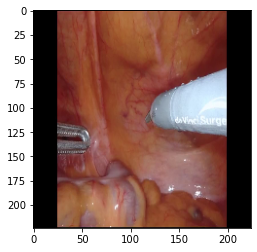

In [10]:
dataset = HerniaDataset(videos[:2], labels_df, all_labels_name, trans)
X, y = dataset[0]
plt.imshow(X.permute(1, 2, 0)), y

In [7]:
dataset.cnts

[1321, 4519]

### Loaders

In [65]:
class_weights = get_class_weights(labels_df, a=0.1)
weights = get_label_weights(labels_df, all_labels_name, class_weights, len(dataset))

In [66]:
loader = DataLoader(dataset, 8, sampler=WeightedRandomSampler(weights, len(dataset), replacement=True))

tensor([[  13,    1,    1,    1,   82, 3116],
        [   6,    1,    1,    1, 2641,  557],
        [  11,    1,    1,    1,  858, 2340],
        [  12,    1,    1,    1,  996,  325],
        [   3,    1,    1,    1, 1947, 1251],
        [  11,    1,    1,    1,  859, 2339],
        [   3,    1,    1,    1, 2202,  996],
        [   9,    1,    1,    1,  336, 2862]])

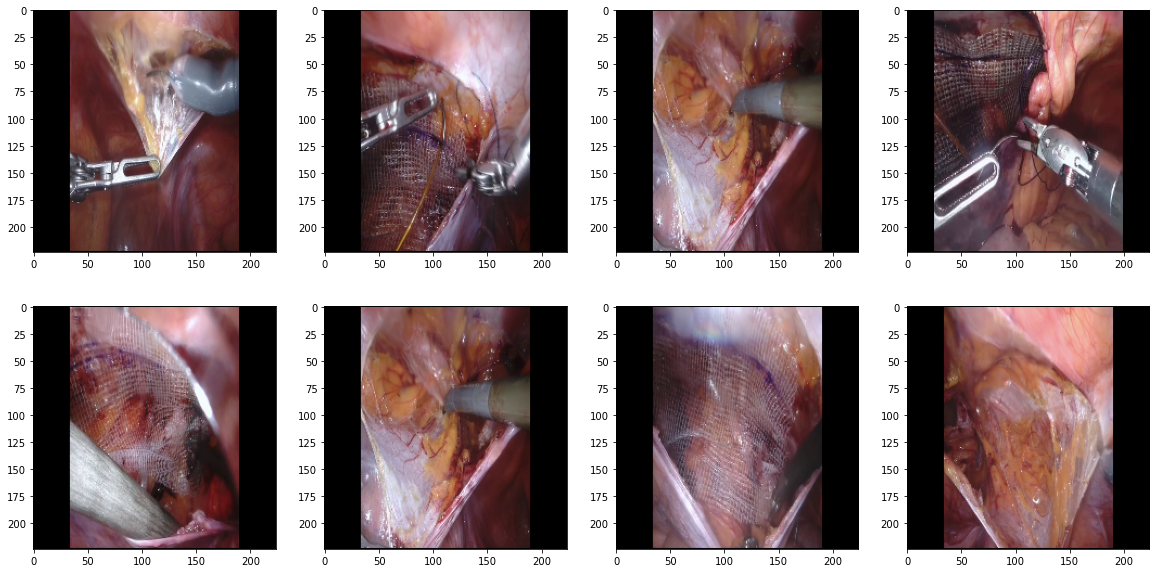

In [67]:
X, y = next(iter(loader))
_, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    ax[i // 4][i % 4].imshow(X[i].permute(1, 2, 0))
y

## Trainers

In [70]:
platform.platform().startswith('mac')

True

## SVRC Dataset

In [23]:
img_paths, labels, class_weights, weights = read(video_base, label_path, name_path, 2)

In [38]:
dataset = SVRCDataset(img_paths, labels, trans)
loader = DataLoader(dataset, 8, sampler=WeightedRandomSampler(weights, len(dataset), replacement=True))

[tensor([11, 11, 11, 13,  9, 13,  3, 11]),
 tensor([1392, 2204, 2820, 3130, 2998, 1855,  679, 2496])]

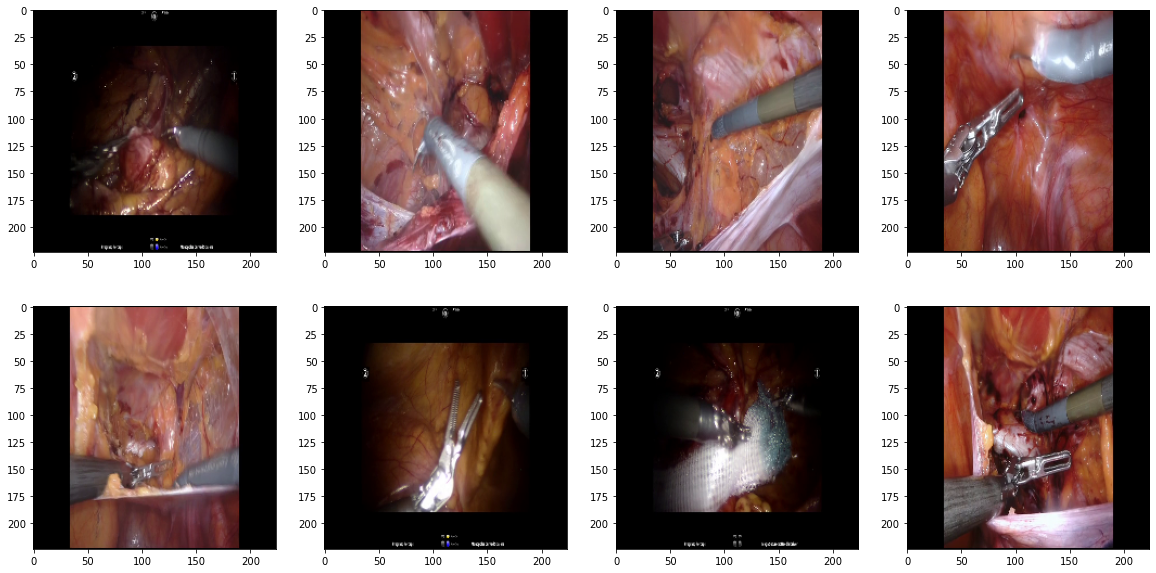

In [44]:
data = next(iter(loader))
_, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    ax[i // 4][i % 4].imshow(data['feature'][i, :3, :, :].permute(1, 2, 0))
data['label']

In [43]:
data['feature'][0, :3, :, :].max()

tensor(1., dtype=torch.float64)